In [1]:
import sys
sys.path.append('../utils')
from nd_tools import lee_filter

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage.restoration import denoise_tv_bregman

The goals of this notebook are:

    
1. Introduce two despeckling techiniques for backscatter images, namely the [Lee Filter](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf) and [Total Variation Denoising](https://www.ipol.im/pub/art/2012/g-tvd/).

2. To inspect how such despeckling improves the classification we began in earlier notebooks.

# Inspecting the Data

In [2]:
data_dir = Path('../data')
backscatter_tifs = sorted(list(data_dir.glob('./*backscatter*.tif')))
backscatter_tifs

[PosixPath('../data/alos_backscatter_hh.tif'),
 PosixPath('../data/alos_backscatter_hv.tif')]

In [3]:
with rasterio.open(backscatter_tifs[0]) as ds:
    hh = ds.read(1)
    profile = ds.profile

with rasterio.open(backscatter_tifs[1]) as ds:
    hv = ds.read(1)

# The Lee Filter

The Lee Filter we are using is from [Stackoverflow](https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python). We compare the variance throughout the image to the variance within a $n\times n$ window. We move the image's pixelwise value closer to the mean within the window proportionally to how close the window's variance matches the image's variance. We have included the code in our utils.

We can compare the original image with the filtered image.

In [4]:
hv_lee = lee_filter(hv, 5)

Text(0.5, 1.0, 'Lee HV')

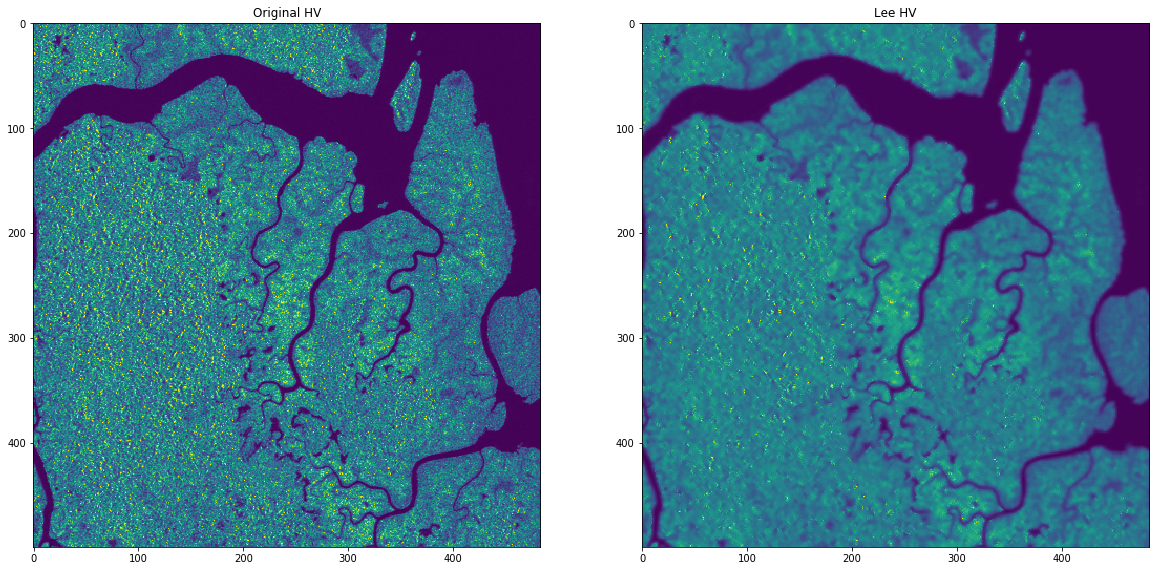

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(hv, vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_lee, vmin=0, vmax=.15)
ax[1].set_title('Lee HV')

Let's zoom in.

Text(0.5, 1.0, 'Lee HV (Size=5)')

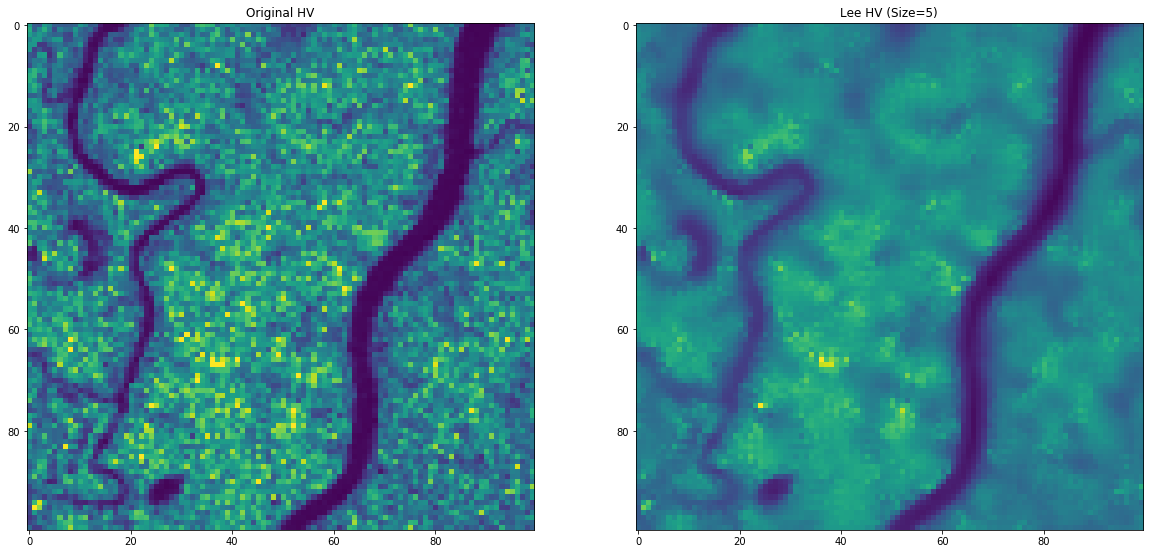

In [6]:
s_index = np.s_[200:300, 200: 300]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(hv[s_index], vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_lee[s_index], vmin=0, vmax=.15)
ax[1].set_title('Lee HV (Size=5)')

## Window sizes and Lee Filters

Let's look at how the size of the window affects the image. Can you explain why larger window sizes apprears to increase the smoothing?

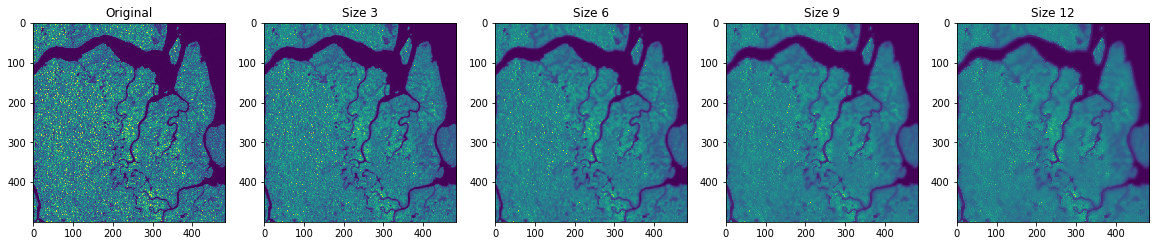

In [7]:
sizes = [0] + list(range(3, 13, 3))
N = len(sizes)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, size) in zip(ax.ravel(), sizes):
    if size == 0:
        ax.imshow(hv, vmin=0, vmax=.15)
        ax.set_title('Original')
    else:
        hv_lee = lee_filter(hv, size) 
        ax.imshow(hv_lee, vmin=0, vmax=.15)
        ax.set_title(f'Size {size}')

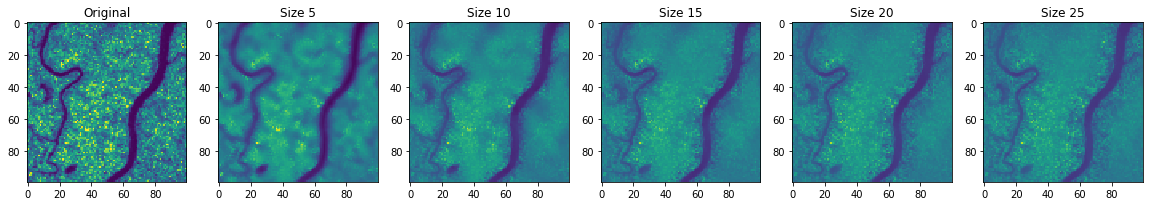

In [8]:
sizes = [0] + list(range(5, 26, 5))
N = len(sizes)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, size) in zip(ax.ravel(), sizes):
    if size == 0:
        ax.imshow(hv[s_index], vmin=0, vmax=.15)
        ax.set_title('Original')
    else:
        hv_lee = lee_filter(hv, size) 
        ax.imshow(hv_lee[s_index], vmin=0, vmax=.15)
        ax.set_title(f'Size {size}')

# Total Variation Denoising

Total variation (TV) denoising refers to the total-variation regularizer $|\nabla f|_1$ to denoise an image with additive noise where we view an image as a function $f$ from the image pixel domain $\Omega$ to $\mathbb R$. This regularizer for image denoising was first introduced in this seminal [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.117.1675&rep=rep1&type=pdf) and a fast method for obtaining such regularized solutions was introduced [here](ftp://ftp.math.ucla.edu/pub/camreport/cam08-29.pdf). Since, TV has become a very popular image processing technique particularly in remote sensing (just [look](https://www.google.com/search?q=total+variation+site%3Aigarss2019.org&oq=total+variation+site%3Aigarss2019.org&aqs=chrome..69i57.7183j0j4&sourceid=chrome&ie=UTF-8) at the number of titles with "total variation" in IGARSS every year!).

Here is nice [tutorial](https://www.ipol.im/pub/art/2012/g-tvd/) on total variation of images with a discussion of the theory and its application. We use the implementation of total variation denoising found in scikit-image for which an example can be found [here](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html).

We will apply TV to SAR using the framework of ["MuLOG"](https://www.charles-deledalle.fr/pages/mulog.php) without debiasing since we are interested in classification and debiasing introduces a constant linear multiple to the $\gamma^0$ image which ultimately won't affect our classification. 

We do the following: we transform the image to decibels so our noise is additive, denoise it with TV, and and then transform it back to linear units.

In [9]:
def fwd(img):
    return 10 * np.log10(img)

def bwd(img):
    return 10**(img / 10)

def tv_denoise(img, weight):
    img_db = fwd(img)
    img_db_tv = denoise_tv_bregman(img_db, weight)
    img_tv = bwd(img_db_tv)
    return img_tv

In [10]:
hv_tv = tv_denoise(hv, 1)

Text(0.5, 1.0, 'TV HV')

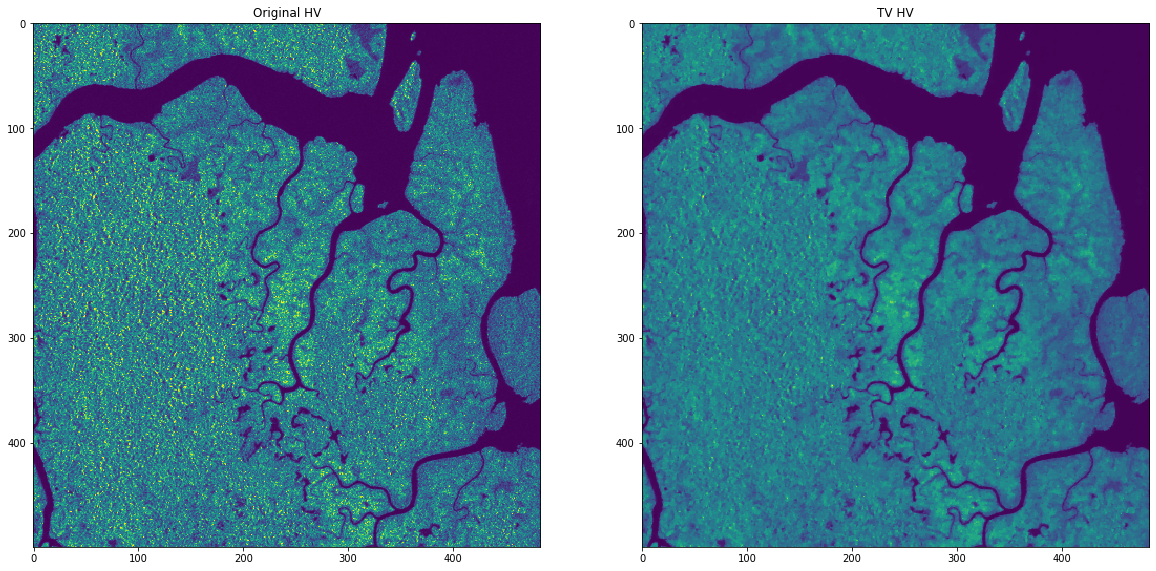

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(hv, vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_tv, vmin=0, vmax=.15)
ax[1].set_title('TV HV')

Text(0.5, 1.0, 'TV HV')

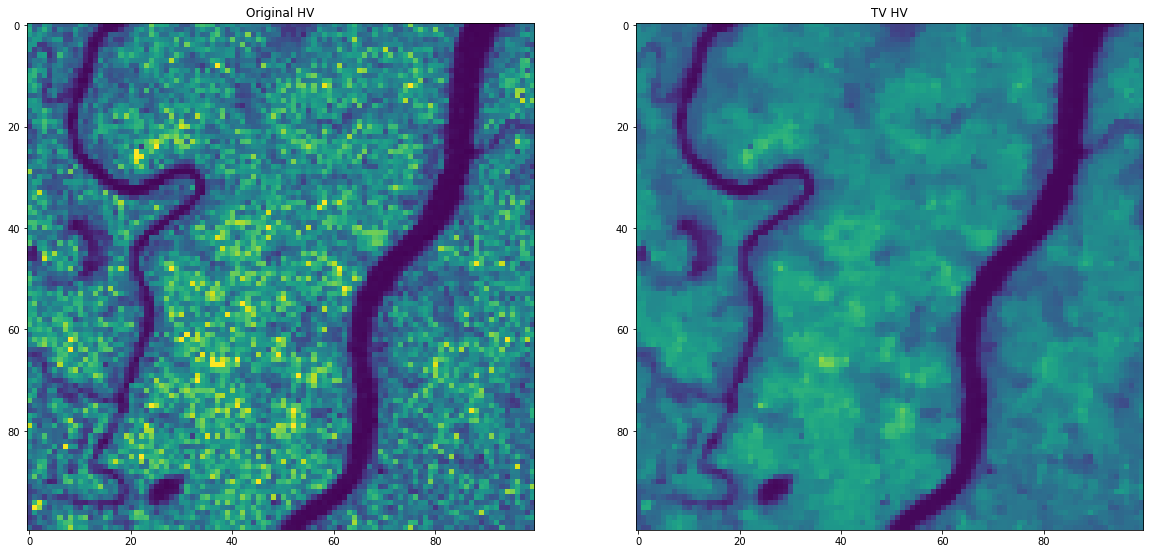

In [12]:
s_index = np.s_[200:300, 200: 300]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(hv[s_index], vmin=0, vmax=.15)
ax[0].set_title('Original HV')

ax[1].imshow(hv_tv[s_index], vmin=0, vmax=.15)
ax[1].set_title('TV HV')


Let's compare weights of TV denoising for HV and HH images.

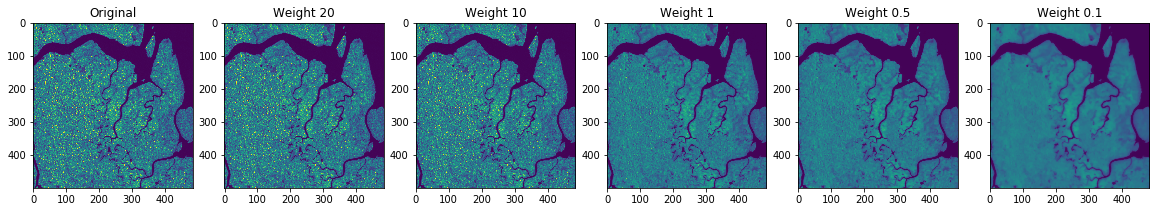

In [13]:
weights = [0] + [20, 10, 1, .5, .1]
N = len(weights)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, weight) in zip(ax.ravel(), weights):
    if weight == 0:
        ax.imshow(hv, vmin=0, vmax=.15)
        ax.set_title('Original')
    else:
        hv_tv = tv_denoise(hv, weight) 
        ax.imshow(hv_tv, vmin=0, vmax=.15)
        ax.set_title(f'Weight {weight}')

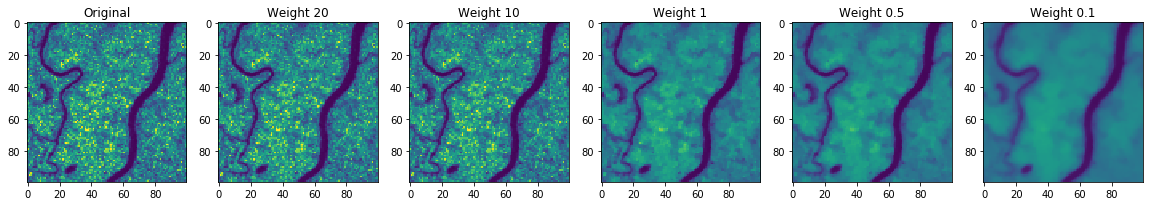

In [14]:
weights = [0] + [20, 10, 1, .5, .1]
N = len(weights)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, weight) in zip(ax.ravel(), weights):
    if weight == 0:
        ax.imshow(hv[s_index], vmin=0, vmax=.15)
        ax.set_title('Original')
    else:
        hv_tv = tv_denoise(hv, weight) 
        ax.imshow(hv_tv[s_index], vmin=0, vmax=.15)
        ax.set_title(f'Weight {weight}')

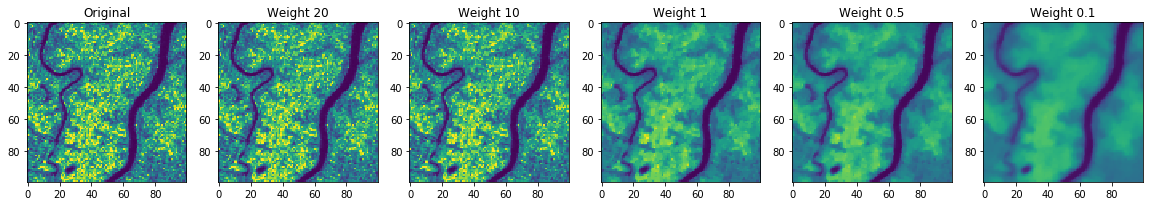

In [15]:
weights = [0] + [20, 10, 1, .5, .1]
N = len(weights)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, weight) in zip(ax.ravel(), weights):
    if weight == 0:
        ax.imshow(hh[s_index], vmin=0, vmax=.5)
        ax.set_title('Original')
    else:
        hh_tv = tv_denoise(hh, weight) 
        ax.imshow(hh_tv[s_index], vmin=0, vmax=.5)
        ax.set_title(f'Weight {weight}')

# Writing our Denoisied Images to TIF

We'll select a weight of .5 and write the rasters to tif. We can then inspect these denoised images in QGIS and compare them to the original images.

This is frequently how I process georferenced images - write a bunch of small functions that do one specific portion of processing and then compose them into a single larger function.

In [16]:
out_dir = Path('out')
out_dir.mkdir(exist_ok=True)

with rasterio.open(backscatter_tifs[0]) as ds:
    reference_profile = ds.profile

In [17]:
def open_one(path):
    with rasterio.open(path) as ds:
        img = ds.read(1)
    return img

def tv_partial(band):
    # this looks like a good weight based on the above inspection
    return tv_denoise(band, .5)

def write_one(band, name):
    dest_path = out_dir/name
    with rasterio.open(dest_path, 'w', **reference_profile) as ds:
        ds.write(band, 1)
    return dest_path
        
def tv_writer(path):
    band = open_one(path)
    band_tv = tv_partial(band)
    print(band_tv.shape)
    dest_path = write_one(band_tv, path.name.replace('.tif', '_tv.tif'))
    return dest_path

In [18]:
list(map(tv_writer, backscatter_tifs))

# this is the same - feel free to uncomment and test
#[tv_writer(path) for path in backscatter_tifs]

(500, 484)
(500, 484)


[PosixPath('out/alos_backscatter_hh_tv.tif'),
 PosixPath('out/alos_backscatter_hv_tv.tif')]

# Excercise 1

Use k-means with three classes using the denoised images. What do you observe?

In [19]:
## Answer

hh_tv = tv_denoise(hh, .5)
hv_tv = tv_denoise(hv, .5)

In [20]:
## Answer

model = KMeans(n_clusters=3, 
               random_state=0)
X_train = np.zeros((hh.size, 2))
X_train[:, 0] = hh_tv.ravel()
X_train[:, 1] = hv_tv.ravel()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

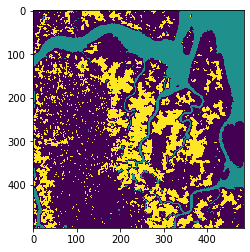

In [21]:
## Answer

classes = model.labels_.reshape(hh.shape)
plt.imshow(classes)

In [22]:
## Answer
profile['dtype'] = 'uint8'
profile['nodata'] = None
with rasterio.open('classes.tif', 'w', **profile) as ds:
    ds.write(classes.astype(np.uint8), 1)

Text(0, 0.5, 'HV (linear)')

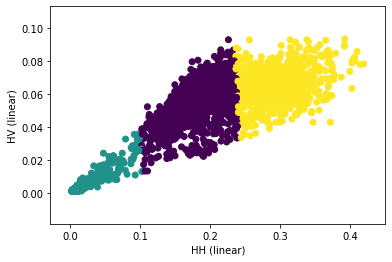

In [23]:
## Answer

N = 4000
indices = np.random.choice(np.arange(hh_tv.size), N)
plt.scatter(hh_tv.ravel()[indices], hv_tv.ravel()[indices], c=classes.ravel()[indices])
plt.xlabel('HH (linear)')
plt.ylabel('HV (linear)')

# Acknowledgements

This tutorial was written by Charlie Marshak and supervised closely by [Marc Simard](https://scholar.google.com/citations?user=JQJF1wgAAAAJ&hl=en). 

This tutorial was for the 2019 SARI training [conference](http://sari.umd.edu/meetings/international-regional-science-training) held at Prince of Songkla University, Phuket Campus. We are grateful to the conference organizers (in particular [Krishna Vadrevu](https://geog.umd.edu/facultyprofile/vadrevu/krishna)), the [SARI program](http://sari.umd.edu/), and the [LCLUC program](https://lcluc.umd.edu/) working to make this training conference possible. We are grateful for the input from and helpful conversations with [Michael Denbina](https://www.researchgate.net/profile/Michael_Denbina), [Tien-Hao Liao](https://scienceandtechnology.jpl.nasa.gov/tien-hao-liao), and Neda Kasraee. 

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2. We are also grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.